In [5]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd

from IPython.display import Image
from Bio import SeqIO


import rpy2.ipython


%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Admixure

In [258]:
%%bash

#clean and create dir if necessary
if [ -d results/admixture ]; then
    rm -r results/admixture
fi
mkdir results/admixture


#since all the rodhaini samples are effectivley from the same host, we are removing all but one before
#  checking for ld
vcftools \
    --vcf results/variant_filtration/smv7_ex_autosomes.vcf \
    --remove-indv ERX284221 \
    --remove-indv ERR310938 \
    --remove-indv Sro_female_1.2_CCGACAAC \
    --remove-indv Sro_female_2.1_CCTAATCC \
    --remove-indv Sro_female_2.2_CCTCTATC \
    --remove-indv Sro_male_1.1_ATCATTCC \
    --remove-indv Sro_male_1.2_ATTGGCTC \
    --remove-indv Sro_male_2.1_CAAGGAGC \
    --remove-indv Sro_male_2.2_CACCTTAC \
    --stdout \
    --recode \
    --recode-INFO-all \
    >results/admixture/smv7_ex_autosomes_no-marg_1-rod.vcf
    
#get ld sites
plink \
    --vcf results/admixture/smv7_ex_autosomes_no-marg_1-rod.vcf \
    --double-id \
    --allow-extra-chr \
    --indep-pairwise 250kb 1 0.20 \
    --out results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld
    
#extract SNPs in LD from file with all rodhaini
vcftools \
    --vcf results/variant_filtration/smv7_ex_autosomes.vcf \
    --exclude results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.prune.out \
    --remove-indv ERX284221 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.vcf

#convert to ped 1/2 format
plink \
    --vcf results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.vcf \
    --out results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld \
    --double-id \
    --recode12 \
    --allow-extra-chr

#create a sample list (for plotting)
grep "#" results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.vcf \
    | tail -n1 \
    | cut -f10- \
    | sed 's/\t/\n/g' \
    >results/admixture/samples.list

PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 250kb 1 0.20
  --out results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld
  --vcf results/admixture/smv7_ex_autosomes_no-marg_1-rod.vcf

24158 MB RAM detected; reserving 12079 MB for main workspace.
Allocated 6794 MB successfully, after larger attempt(s) failed.
--vcf: results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld-temporary.bed +
results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld-temporary.bim +
results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld-temporary.fam written.
475081 variants loaded from .bim file.
147 people (0 males, 0 females, 147 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.nosex .
Using 1 thread (no mult


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/variant_filtration/smv7_ex_autosomes.vcf
	--recode-INFO-all
	--recode
	--stdout
	--remove-indv ERR310938
	--remove-indv ERX284221
	--remove-indv Sro_female_1.2_CCGACAAC
	--remove-indv Sro_female_2.1_CCTAATCC
	--remove-indv Sro_female_2.2_CCTCTATC
	--remove-indv Sro_male_1.1_ATCATTCC
	--remove-indv Sro_male_1.2_ATTGGCTC
	--remove-indv Sro_male_2.1_CAAGGAGC
	--remove-indv Sro_male_2.2_CACCTTAC

Excluding individuals in 'exclude' list
After filtering, kept 147 out of 156 Individuals
Outputting VCF file...
After filtering, kept 475081 out of a possible 475081 Sites
Run Time = 540.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/variant_filtration/smv7_ex_autosomes.vcf
	--recode-INFO-all
	--recode
	--exclude results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.prune.out
	--stdout
	--remove-indv ERX284221

Excluding individu

In [259]:
%%bash

#run unsupervised admixture analysis on k1-20
cd results/admixture
for K in $(seq -w 1 20); do

    CMD="conda activate sch_man_nwinvasion-nbanalyses; admixture \
        --cv \
        -j10 \
        smv7_ex_autosomes_no-marg_1-rod_ld.ped \
        $K \
        >smv7_ex_autosomes_no-marg_1-rod_ld_k$K.log"
        
    echo $CMD | qsub -V -cwd -S /bin/bash -q all.q -j y -N K"$K"_adm_sm -o K"$K"_adm_sm.log -pe smp 12
   
done
cd ../../

Your job 4972080 ("K01_adm_sm") has been submitted
Your job 4972081 ("K02_adm_sm") has been submitted
Your job 4972082 ("K03_adm_sm") has been submitted
Your job 4972083 ("K04_adm_sm") has been submitted
Your job 4972084 ("K05_adm_sm") has been submitted
Your job 4972085 ("K06_adm_sm") has been submitted
Your job 4972086 ("K07_adm_sm") has been submitted
Your job 4972087 ("K08_adm_sm") has been submitted
Your job 4972088 ("K09_adm_sm") has been submitted
Your job 4972089 ("K10_adm_sm") has been submitted
Your job 4972090 ("K11_adm_sm") has been submitted
Your job 4972091 ("K12_adm_sm") has been submitted
Your job 4972092 ("K13_adm_sm") has been submitted
Your job 4972093 ("K14_adm_sm") has been submitted
Your job 4972094 ("K15_adm_sm") has been submitted
Your job 4972095 ("K16_adm_sm") has been submitted
Your job 4972096 ("K17_adm_sm") has been submitted
Your job 4972097 ("K18_adm_sm") has been submitted
Your job 4972098 ("K19_adm_sm") has been submitted
Your job 4972099 ("K20_adm_sm")

In [272]:
%%bash

#create list of easy to work with Q values were samples are labeled/indexed
for K in $(seq 1 20); do

    paste results/admixture/samples.list \
        results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.$K.Q \
        >results/admixture/smv7_ex_autosomes_no-marg_1-rod_ldg.$K.labeled_Q
done


#when all runs are done get CV scores
grep CV results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld*.log \
    | sort -n \
    | awk '{print $3"\t"$4}' \
    | sed 's/(//' \
    | sed 's/)//' \
    | sed 's/://' \
    >results/admixture/cv_table.tsv

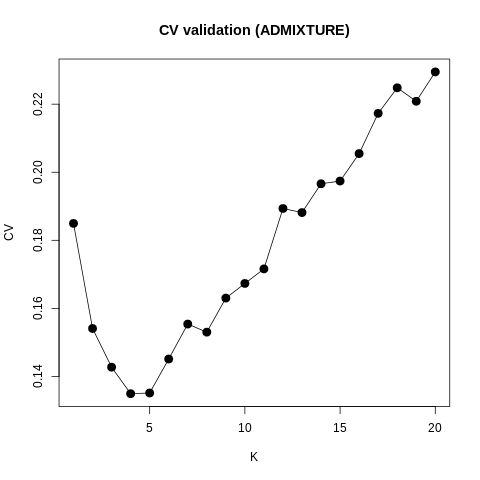

In [275]:
%%R

tbl<-read.table("results/admixture/cv_table.tsv")
colnames(tbl)<-c("k", "cv")

#svg("results/admixture/smv7_ex_autosomes_ld_k1-20_cv_table.svg")
    plot(tbl$cv, 
         type="o", 
         pch=19, 
         cex=1.5, 
         xlab="K", 
         ylab="CV", 
         main="CV validation (ADMIXTURE)")
#dev.off()

In [278]:
%%R

svg("results/admixture/smv7_ex_autosomes_ld_k4-5.svg")
    space=c(rep(0.1, 9),
            5,
            rep(0.1, 2), 5, rep(0.1, 47),
            5,
            rep(0.1, 10), 2, rep(0.1, 25),
            5,
            rep(0.1, 2), 2, rep(0.1, 55)
            )

    par(mfrow=c(2,1),
    mar=c(0.25,4,1.5,0.25))

    for (k in seq(4,5)){
        
        tbl=read.table(paste("results/admixture/smv7_ex_autosomes_no-marg_1-rod_ld.", k, ".Q", sep=""))
        
        barplot(t(as.matrix(tbl)), 
                col=rainbow(k),
                xlab="", 
                ylab=paste("k=", k, sep=""), 
                border=NA,
                space=space
        )
    }
dev.off()


png 
  2 


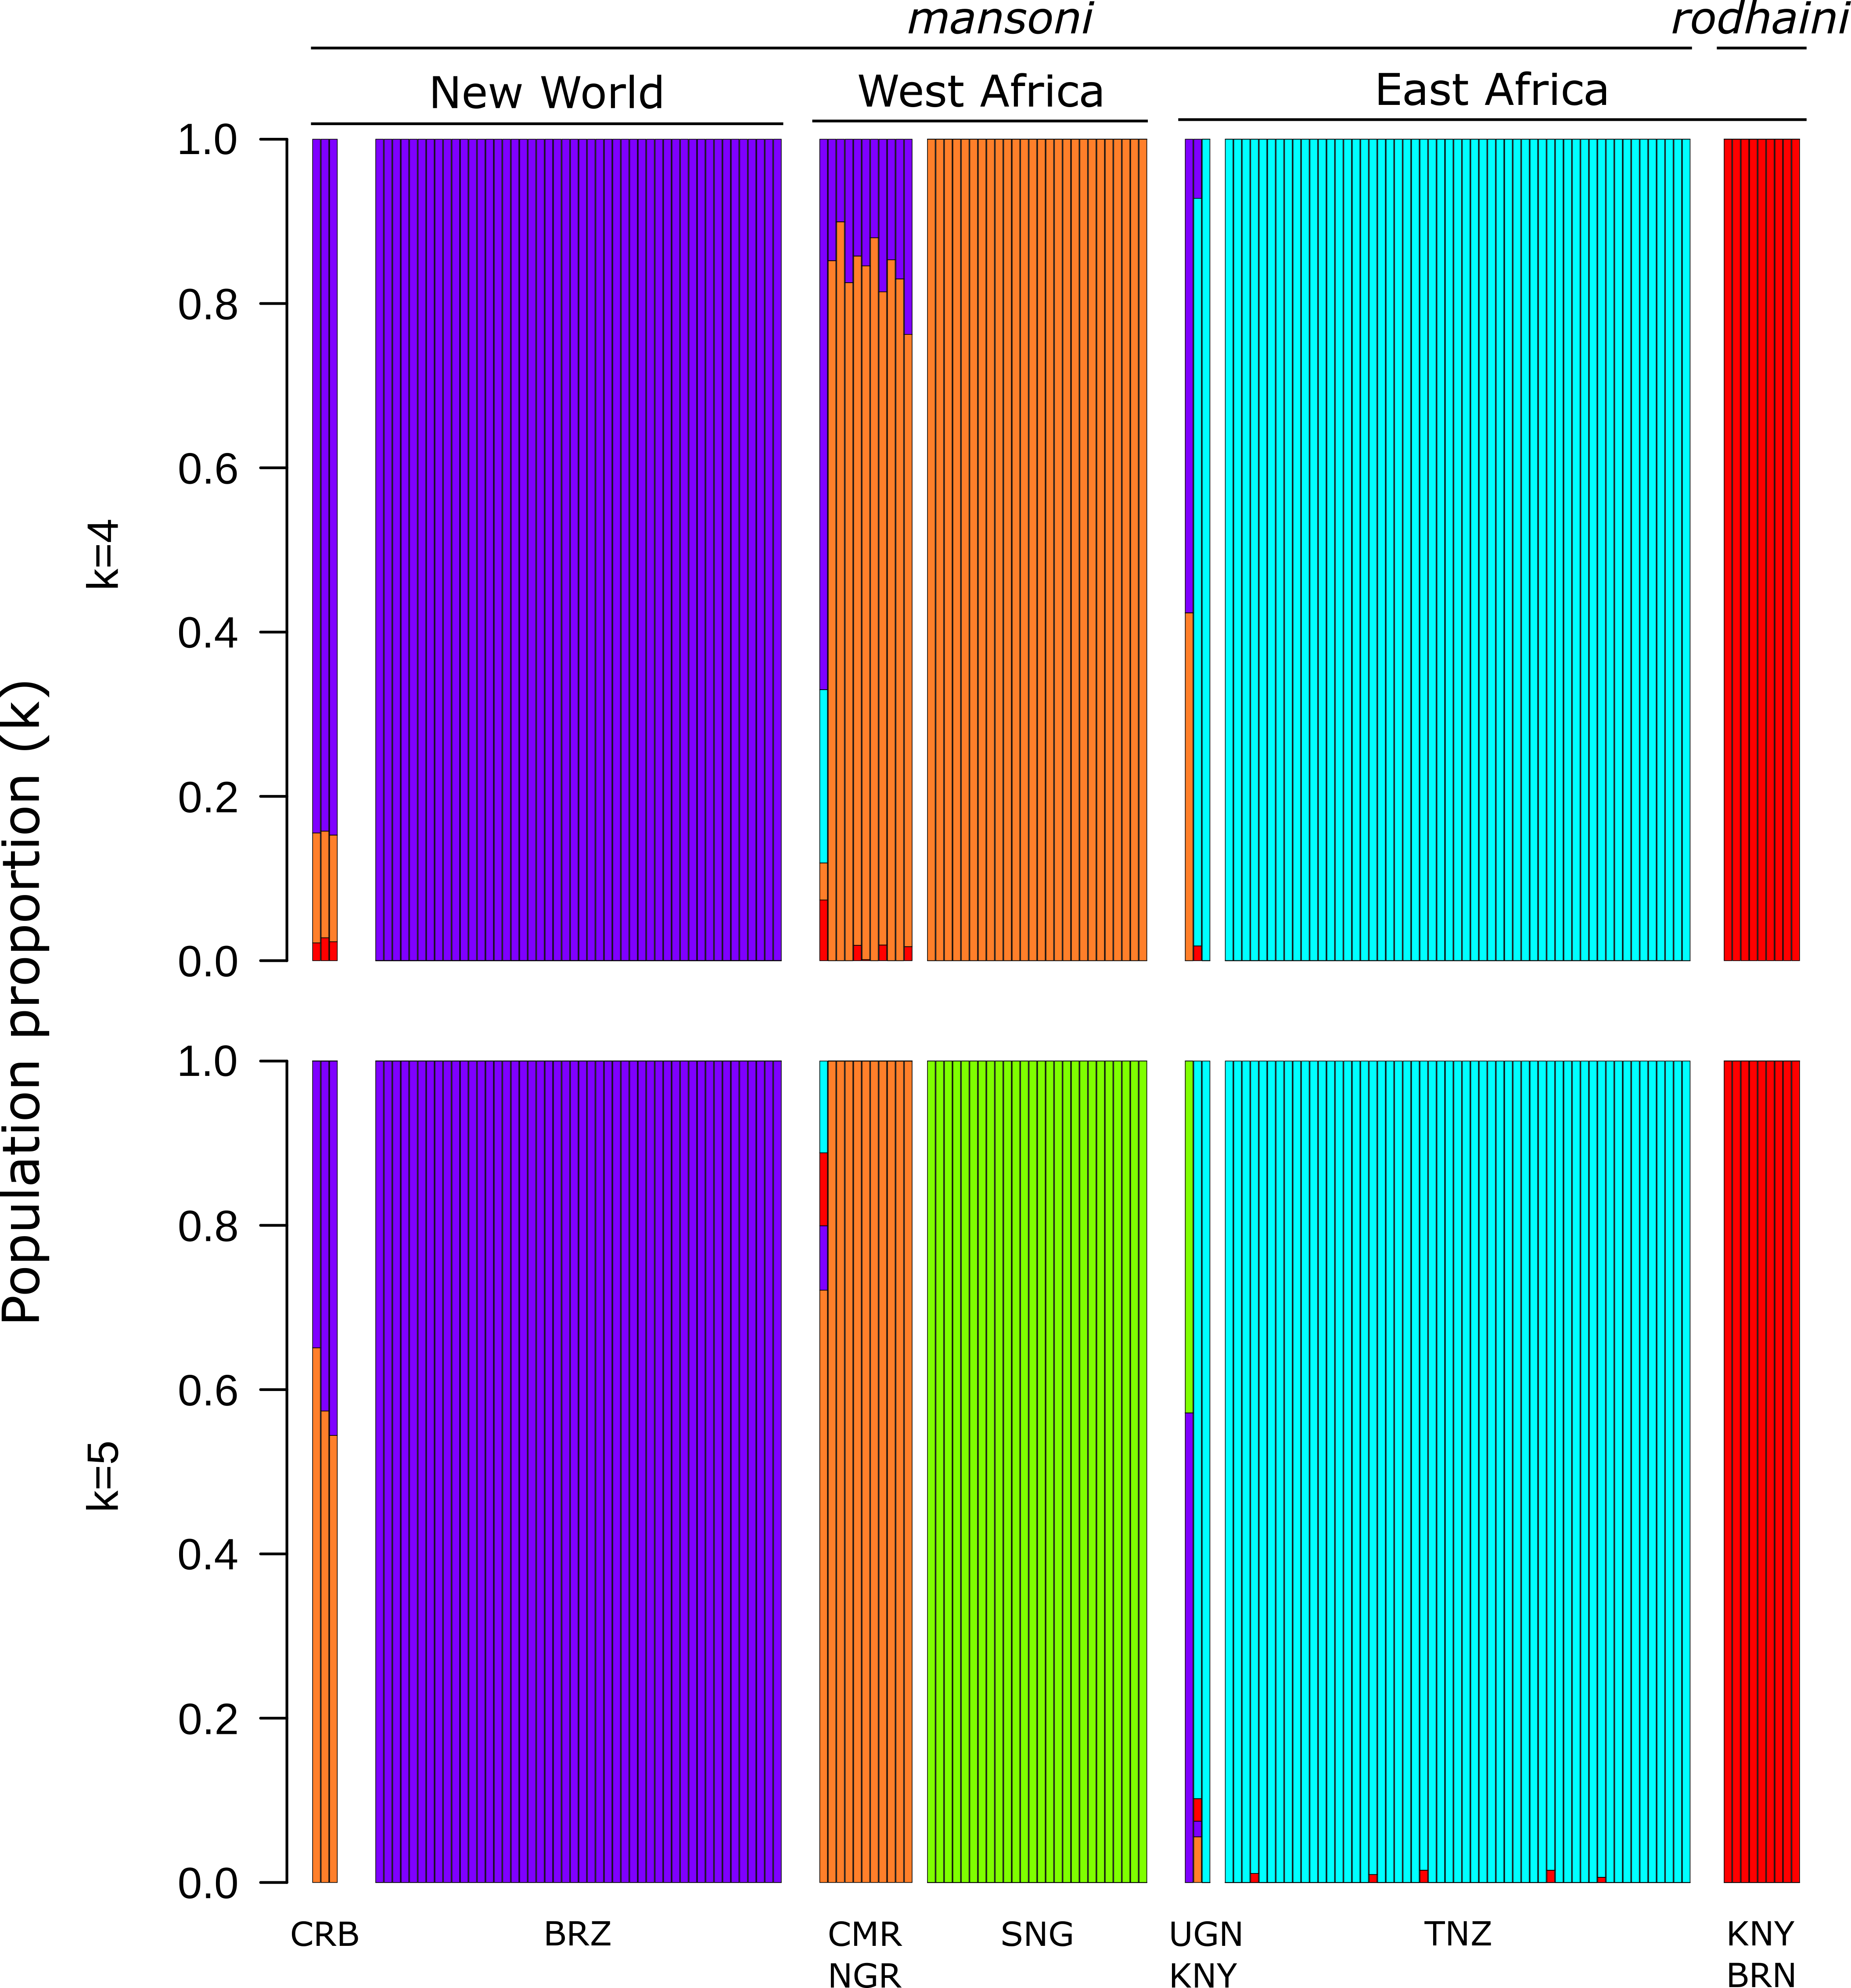

In [279]:
Image(filename="results/admixture/smv7_ex_autosomes_ld_k4-5_mod.png")

# PCA

In [218]:
#make a clean dir
if os.path.isdir("results/pca"):
    shutil.rmtree("results/pca")
os.mkdir("results/pca")

## PCA w/o rodhaini

In [228]:
%%bash

vcftools \
    --vcf results/variant_filtration/smv7_ex_autosomes.vcf \
    --remove-indv ERX284221 \
    --remove-indv Sro_female_1.2_CCGACAAC \
    --remove-indv Sro_female_2.1_CCTAATCC \
    --remove-indv Sro_female_2.2_CCTCTATC \
    --remove-indv Sro_male_1.1_ATCATTCC \
    --remove-indv Sro_male_1.2_ATTGGCTC \
    --remove-indv Sro_male_2.1_CAAGGAGC \
    --remove-indv Sro_male_2.2_CACCTTAC \
    --stdout \
    --recode \
    --recode-INFO-all \
    >results/pca/smv7_ex_autosomes_no-marg_1rod.vcf
    
#convert to ped 1/2 format
plink \
    --vcf results/pca/smv7_ex_autosomes_no-marg_1rod.vcf \
    --out results/pca/smv7_ex_autosomes_no-marg_1rod \
    --double-id \
    --recode12 \
    --allow-extra-chr

#create a sample list (for plotting)
grep "#" results/pca/smv7_ex_autosomes_no-marg_1rod.vcf \
    | tail -n1 \
    | cut -f10- \
    | sed 's/\t/\n/g' \
    >results/pca/samples_no-marg_1rod.list

#run PCA
plink \
    --vcf results/pca/smv7_ex_autosomes_no-marg_1rod.vcf \
    --double-id \
    --pca \
    --allow-extra-chr \
    --out results/pca/smv7_ex_autosomes_no-marg_1rod_pca


PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use 'recode 12 ...'.
Logging to results/pca/smv7_ex_autosomes_no-marg_1rod.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/pca/smv7_ex_autosomes_no-marg_1rod
  --recode 12
  --vcf results/pca/smv7_ex_autosomes_no-marg_1rod.vcf

24158 MB RAM detected; reserving 12079 MB for main workspace.
Allocated 6794 MB successfully, after larger attempt(s) failed.
--vcf: results/pca/smv7_ex_autosomes_no-marg_1rod-temporary.bed +
results/pca/smv7_ex_autosomes_no-marg_1rod-temporary.bim +
results/pca/smv7_ex_autosomes_no-marg_1rod-temporary.fam written.
475081 variants loaded from .bim file.
148 people (0 males, 0 females, 148 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/pca/smv7_ex_autosomes_no-marg_1rod.nosex .
Using 1 thread (no multithreaded calculations invoke


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/variant_filtration/smv7_ex_autosomes.vcf
	--recode-INFO-all
	--recode
	--stdout
	--remove-indv ERX284221
	--remove-indv Sro_female_1.2_CCGACAAC
	--remove-indv Sro_female_2.1_CCTAATCC
	--remove-indv Sro_female_2.2_CCTCTATC
	--remove-indv Sro_male_1.1_ATCATTCC
	--remove-indv Sro_male_1.2_ATTGGCTC
	--remove-indv Sro_male_2.1_CAAGGAGC
	--remove-indv Sro_male_2.2_CACCTTAC

Excluding individuals in 'exclude' list
After filtering, kept 148 out of 156 Individuals
Outputting VCF file...
After filtering, kept 475081 out of a possible 475081 Sites
Run Time = 581.00 seconds


In [5]:
%%R

pop_colors <- c("tanzania"      = "green4",
                "uganda"        = "darkolivegreen1",
                "kenya"         = "green",
                "cameroon"      = "red",
                "niger"         = "deeppink",
                "senegal"       = "salmon",
                "brazil"        = "blue",
                "caribbean"     = "steelblue1")

shapes <- c("genome" = 24,
            "exome"  = 21 )

eg_vec<-read.table("../sch_man_nwinvasion/results/pca/smv7_ex_autosomes_no-marg_1rod_pca.eigenvec", header=FALSE)
eg_val<-read.table("../sch_man_nwinvasion/results/pca/smv7_ex_autosomes_no-marg_1rod_pca.eigenval", header=FALSE)
samples<-scan("../sch_man_nwinvasion/results/pca/samples_no-marg_1rod.list", what="character")


colors<-c( rep(pop_colors["caribbean"], 3),
           rep(pop_colors["brazil"],    48),
           rep(pop_colors["cameroon"],  1),
           rep(pop_colors["niger"],     10),
           rep(pop_colors["senegal"],   26),
           rep(pop_colors["kenya"],     1),
           rep(pop_colors["uganda"],    2),
           rep(pop_colors["tanzania"],  55) )

shapes<-c( rep(shapes["genome"],  3),
           rep(shapes["exome"],  48),
           rep(shapes["genome"],  1),
           rep(shapes["exome"],  10),
           rep(shapes["genome"],  1),
           rep(shapes["exome"],  25),
           rep(shapes["genome"],  3),
           rep(shapes["exome"],  55) )

PC1_val<-eg_val$V1[1]
PC2_val<-eg_val$V1[2]

#par(mfrow=c(1,2))
svg("results/pca/smv7_ex_autosomes_no-marg_1rod_pca.svg")
    plot(eg_vec$V3, eg_vec$V4, 
         cex  =2, 
         pch  =shapes, 
         bg   =colors, 
         col  ="black",
         xlab =paste("PC1 (", round(PC1_val, digits=2), "%)"),
         ylab =paste("PC2 (", round(PC2_val, digits=2), "%)"),
        #main="PCA unlinked autosomes"
        )
        
    legend(-0.135, -0.030, 
           legend=c("Caribbean", 
                    "Brazil", 
                    "Cameroon", 
                    "Niger", 
                    "Senegal", 
                    "Kenya", 
                    "Uganda", 
                    "Tanzania"),
           pch=19,
           col=c(pop_colors["caribbean"],
                 pop_colors["brazil"],
                 pop_colors["cameroon"],
                 pop_colors["niger"],
                 pop_colors["senegal"],
                 pop_colors["kenya"],
                 pop_colors["uganda"],
                 pop_colors["tanzania"] ),
           title="Location",
           cex=1.25
           )

    legend(-0.07, -0.15, 
          legend  = c("Exome", "Genome"),
          pch   = c(19, 17),
          title="Data Type",
          cex=1.25
               
           )
dev.off()

#svg("results/pca/smv7_ex_autosomes_no-marg_1rod_pca_eigenvalues.svg")
    barplot(eg_val$V1,
            ylim=c(0,max(eg_val$V1)*1.2),
            col=c(rep("black", 2), rep("white", 18)),
            main="Eigenvalues (schMan_v7_autosomes_ld)")
#dev.off()

UsageError: Cell magic `%%R` not found.


## PCA w rodhaini

In [231]:
%%bash

vcftools \
    --vcf results/variant_filtration/smv7_ex_autosomes.vcf \
    --remove-indv ERX284221 \
    --remove-indv ERR310938 \
    --remove-indv Sro_female_1.1_CCATCCTC \
    --remove-indv Sro_female_1.2_CCGACAAC \
    --remove-indv Sro_female_2.1_CCTAATCC \
    --remove-indv Sro_female_2.2_CCTCTATC \
    --remove-indv Sro_male_1.1_ATCATTCC \
    --remove-indv Sro_male_1.2_ATTGGCTC \
    --remove-indv Sro_male_2.1_CAAGGAGC \
    --remove-indv Sro_male_2.2_CACCTTAC \
    --stdout \
    --recode \
    --recode-INFO-all \
    >results/pca/smv7_ex_autosomes_no-marg_no-rod.vcf
    
#convert to ped 1/2 format
plink \
    --vcf results/pca/smv7_ex_autosomes_no-marg_no-rod.vcf \
    --out results/pca/smv7_ex_autosomes_no-marg_no-rod \
    --double-id \
    --recode12 \
    --allow-extra-chr

#create a sample list (for plotting)
grep "#" results/pca/smv7_ex_autosomes_no-marg_no-rod.vcf \
    | tail -n1 \
    | cut -f10- \
    | sed 's/\t/\n/g' \
    >results/pca/samples_no-marg_no-rod.list

#run PCA
plink \
    --vcf results/pca/smv7_ex_autosomes_no-marg_no-rod.vcf \
    --double-id \
    --pca \
    --allow-extra-chr \
    --out results/pca/smv7_ex_autosomes_no-marg_no-rod_pca


PLINK v1.90b4 64-bit (20 Mar 2017)             www.cog-genomics.org/plink/1.9/
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use 'recode 12 ...'.
Logging to results/pca/smv7_ex_autosomes_no-marg_no-rod.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/pca/smv7_ex_autosomes_no-marg_no-rod
  --recode 12
  --vcf results/pca/smv7_ex_autosomes_no-marg_no-rod.vcf

24158 MB RAM detected; reserving 12079 MB for main workspace.
Allocated 6794 MB successfully, after larger attempt(s) failed.
--vcf: results/pca/smv7_ex_autosomes_no-marg_no-rod-temporary.bed +
results/pca/smv7_ex_autosomes_no-marg_no-rod-temporary.bim +
results/pca/smv7_ex_autosomes_no-marg_no-rod-temporary.fam written.
475081 variants loaded from .bim file.
146 people (0 males, 0 females, 146 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/pca/smv7_ex_autosomes_no-marg_no-rod.nosex
.
Using 1 thread (no multithreaded calcu


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf results/variant_filtration/smv7_ex_autosomes.vcf
	--recode-INFO-all
	--recode
	--stdout
	--remove-indv ERR310938
	--remove-indv ERX284221
	--remove-indv Sro_female_1.1_CCATCCTC
	--remove-indv Sro_female_1.2_CCGACAAC
	--remove-indv Sro_female_2.1_CCTAATCC
	--remove-indv Sro_female_2.2_CCTCTATC
	--remove-indv Sro_male_1.1_ATCATTCC
	--remove-indv Sro_male_1.2_ATTGGCTC
	--remove-indv Sro_male_2.1_CAAGGAGC
	--remove-indv Sro_male_2.2_CACCTTAC

Excluding individuals in 'exclude' list
After filtering, kept 146 out of 156 Individuals
Outputting VCF file...
After filtering, kept 475081 out of a possible 475081 Sites
Run Time = 619.00 seconds


In [240]:
%%R

pop_colors <- c("tanzania"      = "green4",
                "uganda"        = "darkolivegreen1",
                "kenya"         = "green",
                "cameroon"      = "red",
                "niger"         = "deeppink",
                "senegal"       = "salmon",
                "brazil"        = "blue",
                "caribbean"     = "steelblue1",
                "rodhaini"      = "grey")

shapes <- c("genome" = 24,
            "exome"  = 21 )

eg_vec<-read.table("../sch_man_nwinvasion/results/pca/smv7_ex_autosomes_no-marg_no-rod_pca.eigenvec", header=FALSE)
eg_val<-read.table("../sch_man_nwinvasion/results/pca/smv7_ex_autosomes_no-marg_no-rod_pca.eigenval", header=FALSE)
samples<-scan("../sch_man_nwinvasion/results/pca/samples_no-marg_no-rod.list", what="character")


colors<-c( rep(pop_colors["rodhaini"],  0),
           rep(pop_colors["caribbean"], 3),
           rep(pop_colors["brazil"],    48),
           rep(pop_colors["cameroon"],  1),
           rep(pop_colors["niger"],     10),
           rep(pop_colors["senegal"],   26),
           rep(pop_colors["kenya"],     1),
           rep(pop_colors["uganda"],    2),
           rep(pop_colors["tanzania"],  55) )

shapes<-c( rep(shapes["genome"],  0),
           rep(shapes["exome"],   0),
           rep(shapes["genome"],  3),
           rep(shapes["exome"],  48),
           rep(shapes["genome"],  1),
           rep(shapes["exome"],  10),
           rep(shapes["genome"],  1),
           rep(shapes["exome"],  25),
           rep(shapes["genome"],  3),
           rep(shapes["exome"],  55) )

PC1_val<-eg_val$V1[1]
PC2_val<-eg_val$V1[2]

#par(mfrow=c(1,2))
svg("results/pca/smv7_ex_autosomes_no-marg_no-rod_pca.svg")
    plot(eg_vec$V3, eg_vec$V4, 
         cex  =2, 
         pch  =shapes, 
         bg   =colors, 
         col  ="black",
         xlab =paste("PC1 (", round(PC1_val, digits=2), "%)"),
         ylab =paste("PC2 (", round(PC2_val, digits=2), "%)"),
        #main="PCA unlinked autosomes"
        )
        
    legend(-0.1, -0.025, 
           legend=c("Caribbean", 
                    "Brazil", 
                    "Cameroon", 
                    "Niger", 
                    "Senegal", 
                    "Kenya", 
                    "Uganda", 
                    "Tanzania" ),
           pch=15,
           col=c(pop_colors["caribbean"],
                 pop_colors["brazil"],
                 pop_colors["cameroon"],
                 pop_colors["niger"],
                 pop_colors["senegal"],
                 pop_colors["kenya"],
                 pop_colors["uganda"],
                 pop_colors["tanzania"]),
           title="Location",
           cex=1.25
           )

    legend(-0.04, -0.1, 
          legend  = c("Exome", "Genome"),
          pch   = c(19, 17),
          title="Data Type",
          cex=1.25
               
           )
dev.off()

svg("results/pca/smv7_ex_autosomes_no-marg_no-rod_pca_eigenvalues.svg")
    barplot(eg_val$V1,
            ylim=c(0,max(eg_val$V1)*1.2),
            col=c(rep("black", 2), rep("white", 18)),
            main="Eigenvalues (schMan_v7_autosomes_ld)")
dev.off()

png 
  2 


## PCA results

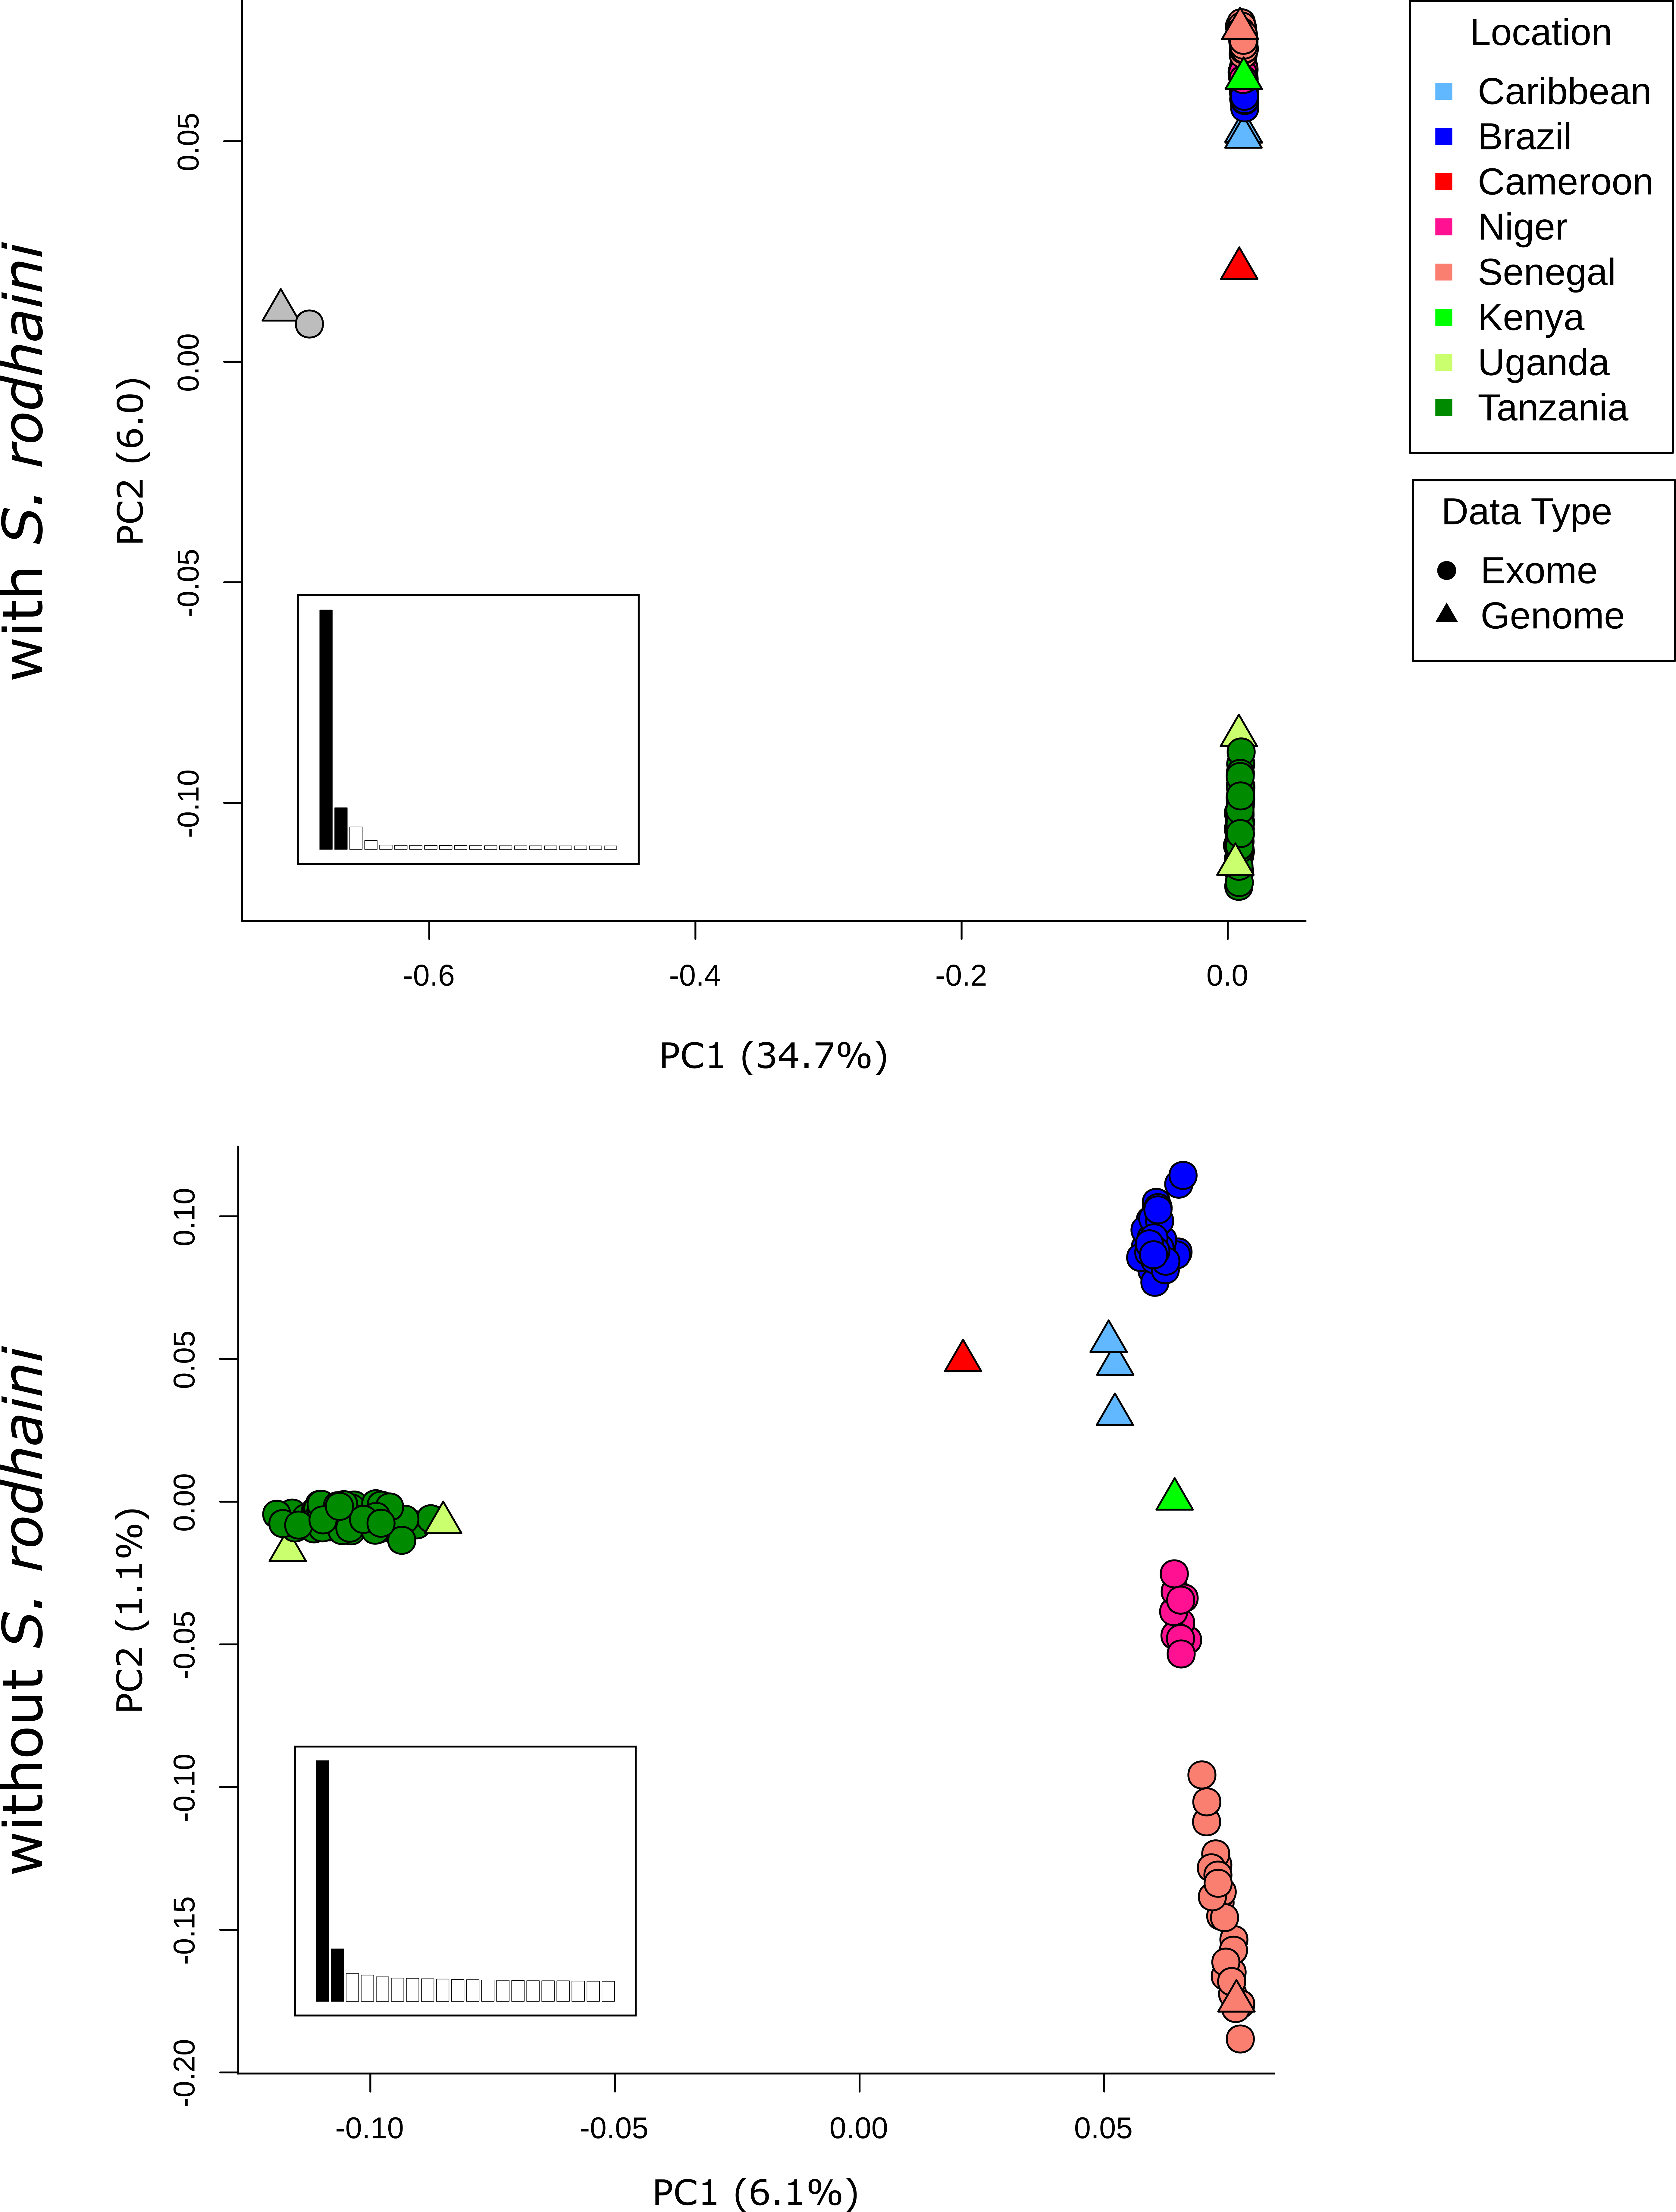

In [249]:
Image(filename="results/pca/smv7_ex_autosomes_pca_mod.png")